<a href="https://colab.research.google.com/github/afnankhan123456/Data-Analysis/blob/main/deep_imaegs_probem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # Yeh command file upload karne ke liye hai


In [2]:
import os

print(os.listdir('/content'))  # Check the contents of /content directory


['.config', 'segment_dataset.zip', 'sample_data']


In [3]:
!unzip -oq /content/segment_dataset.zip -d /content/dataset/



In [4]:
import os

dataset_path = 'dataset'

for split_folder in os.listdir(dataset_path):
    split_path = os.path.join(dataset_path, split_folder)
    if os.path.isdir(split_path):
        total_images = 0
        for root, dirs, files in os.walk(split_path):
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            total_images += len(image_files)
        print(f"{split_folder} --> {total_images} images")


seg_train --> 14034 images
seg_test --> 3000 images
seg_pred --> 7301 images


In [5]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.6 MB/s eta 0:00:00


# **DATA** **CLEANING**

In [6]:
import os
from PIL import Image
import imagehash
import cv2

def clean_data(dataset_path, min_size=(50, 50), blur_threshold=100):
    corrupt_images = []
    non_image_files = []
    empty_folders = []
    duplicate_hashes = set()
    duplicate_images = []
    unusual_size_images = []
    class_counts = {}
    blurry_images = []
    wrong_class_images = []

    for root, dirs, files in os.walk(dataset_path):
        if not files and not dirs:
            empty_folders.append(root)

        for file in files:
            file_path = os.path.join(root, file)

            # Non-image file
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                non_image_files.append(file_path)
                continue

            # Corrupt image
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                corrupt_images.append(file_path)
                continue

            # Unusual size
            try:
                with Image.open(file_path) as img:
                    if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
                        unusual_size_images.append(file_path)
            except:
                continue

            # Duplicate detection
            try:
                with Image.open(file_path) as img:
                    hash_val = imagehash.average_hash(img)
                    if hash_val in duplicate_hashes:
                        duplicate_images.append(file_path)
                    else:
                        duplicate_hashes.add(hash_val)
            except:
                continue

            # Blurry image check
            try:
                img = cv2.imread(file_path)
                if img is None:
                    continue
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                variance = cv2.Laplacian(gray, cv2.CV_64F).var()
                if variance < blur_threshold:
                    blurry_images.append(file_path)
            except:
                continue

    # Class distribution
    for root, dirs, _ in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            if os.path.isdir(folder_path):
                image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                class_counts[folder] = len(image_files)
                for sub_root, _, sub_files in os.walk(folder_path):
                    sub_image_files = [f for f in sub_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                    class_counts[folder] += len(sub_image_files)

    # Print report
    print(f"\nCorrupt Images: {len(corrupt_images)}")
    print(f"Non-Image Files: {len(non_image_files)}")
    print(f"Empty Folders: {len(empty_folders)}")
    print(f"Duplicate Images: {len(duplicate_images)}")
    print(f"Unusual Size Images: {len(unusual_size_images)}")
    print(f"Class Distribution: {class_counts}")
    print(f"Blurry Images Found: {len(blurry_images)}")
    print(f"Wrong Class Images (manual check): {len(wrong_class_images)}")

    return blurry_images

# Example usage
dataset_path = 'dataset'
blurry_images = clean_data(dataset_path)  # is list ko next code me use karna



Corrupt Images: 0
Non-Image Files: 0
Empty Folders: 0
Duplicate Images: 2501
Unusual Size Images: 0
Class Distribution: {'seg_train': 14034, 'seg_test': 3000, 'seg_pred': 14602, 'buildings': 874, 'sea': 1020, 'forest': 948, 'glacier': 1106, 'street': 1002, 'mountain': 1050}
Blurry Images Found: 30
Wrong Class Images (manual check): 0


In [7]:
def delete_duplicates(dataset_path):
    seen = set()
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                try:
                    hash = str(imagehash.average_hash(Image.open(img_path)))
                    if hash in seen: os.remove(img_path)
                    else: seen.add(hash)
                except:
                    continue

delete_duplicates('dataset')


In [8]:
def delete_blurry_images(blurry_images):
    print("\nDeleting blurry images...")
    for img_path in blurry_images:
        try:
            if os.path.exists(img_path):
                os.remove(img_path)
                print(f"Deleted: {img_path}")
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

# Example usage
delete_blurry_images(blurry_images)



Deleting blurry images...
Deleted: dataset/seg_train/seg_train/glacier/3874.jpg
Deleted: dataset/seg_train/seg_train/mountain/2320.jpg
Deleted: dataset/seg_train/seg_train/mountain/8742.jpg
Deleted: dataset/seg_train/seg_train/mountain/14283.jpg
Deleted: dataset/seg_train/seg_train/mountain/18884.jpg
Deleted: dataset/seg_pred/seg_pred/23235.jpg
Deleted: dataset/seg_pred/seg_pred/18747.jpg
Deleted: dataset/seg_pred/seg_pred/17556.jpg


## **DATA** **PREPROCESING**

In [9]:
print(os.listdir('/content/dataset/seg_train/seg_train'))  # Check contents of nested seg_train folder


['buildings', 'sea', 'forest', 'glacier', 'street', 'mountain']


In [10]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

def preprocess_image(image_path, target_size=(224, 224), grayscale=False):
    img = Image.open(image_path)  # Image load
    img = img.resize(target_size)  # Resizing image to target size

    if grayscale:  # Grayscale Conversion (optional)
        img = img.convert('L')

    img_array = np.array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalization / Pixel Scaling
    img_array = cv2.GaussianBlur(img_array, (3, 3), 0)  # Noise Removal

    # Image Cropping (optional, center crop)
    h, w = img_array.shape[:2]
    img_array = img_array[h//4:h//2, w//4:w//2]

    # Skip color conversion if grayscale
    if not grayscale:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)  # Color Space Conversion (RGB to HSV)

    return img_array

def augment_image(image_path, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        rotation_range=40,  # Random rotation
        width_shift_range=0.2,  # Horizontal shift
        height_shift_range=0.2,  # Vertical shift
        zoom_range=0.2,  # Zoom
        horizontal_flip=True  # Flip horizontally
    )

    img = image.load_img(image_path, target_size=target_size)  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions

    return datagen.flow(img_array, batch_size=1)  # Augmented image

def process_images_from_folder(dataset_path):
    # Loop through all folders inside the dataset
    for root, dirs, files in os.walk(dataset_path):
        # Check if the folder contains image files
        image_files = [f for f in files if f.lower().endswith(('jpg', 'jpeg', 'png'))]

        # Process images if found in the current folder
        if image_files:
            print(f"Processing images from folder: {root}")
            for image_file in image_files:
                image_path = os.path.join(root, image_file)
                preprocessed_image = preprocess_image(image_path, grayscale=True)  # Process the image
                augmented_images = augment_image(image_path)  # Augment the image
                print(f"Processed: {image_path}")  # Print the image path after processing

# Example usage
dataset_path = '/content/dataset'  # Path to your dataset folder (seg_train, seg_test, etc.)
process_images_from_folder(dataset_path)


Streaming output truncated to the last 5000 lines.
Processed: /content/dataset/seg_pred/seg_pred/565.jpg
Processed: /content/dataset/seg_pred/seg_pred/23970.jpg
Processed: /content/dataset/seg_pred/seg_pred/22190.jpg
Processed: /content/dataset/seg_pred/seg_pred/10377.jpg
Processed: /content/dataset/seg_pred/seg_pred/9837.jpg
Processed: /content/dataset/seg_pred/seg_pred/939.jpg
Processed: /content/dataset/seg_pred/seg_pred/19181.jpg
Processed: /content/dataset/seg_pred/seg_pred/17879.jpg
Processed: /content/dataset/seg_pred/seg_pred/1289.jpg
Processed: /content/dataset/seg_pred/seg_pred/4430.jpg
Processed: /content/dataset/seg_pred/seg_pred/24117.jpg
Processed: /content/dataset/seg_pred/seg_pred/18774.jpg
Processed: /content/dataset/seg_pred/seg_pred/17199.jpg
Processed: /content/dataset/seg_pred/seg_pred/2146.jpg
Processed: /content/dataset/seg_pred/seg_pred/13974.jpg
Processed: /content/dataset/seg_pred/seg_pred/20721.jpg
Processed: /content/dataset/seg_pred/seg_pred/7405.jpg
Proces

In [ ]:
# folder stacture btayagea

def print_folder_structure(dataset_path, max_images=5):
    # Walk through all subdirectories and files in the given directory
    for root, dirs, files in os.walk(dataset_path):
        # Print the folder path
        print(f"Folder: {root}")

        # Print subfolders if they exist
        if dirs:
            print(f"  Subfolders: {dirs}")

        # Filter out image files (jpg, jpeg, png)
        image_files = [f for f in files if f.lower().endswith(('jpg', 'jpeg', 'png'))]

        if image_files:
            # Print only up to the max_images specified
            print(f"  Images (showing first {min(len(image_files), max_images)}):")
            for i, image in enumerate(image_files[:max_images]):
                print(f"    {image}")
            # If more images exist, indicate it
            if len(image_files) > max_images:
                print(f"    ...and {len(image_files) - max_images} more images")

# Example usage
dataset_path = '/content/dataset'  # Path to your dataset folder (seg_train, seg_test, etc.)
max_images = 3  # Set the limit for showing images
print_folder_structure(dataset_path, max_images)


Folder: /content/dataset
  Subfolders: ['seg_train', 'seg_pred', 'seg_test']
Folder: /content/dataset/seg_train
  Subfolders: ['seg_train']
Folder: /content/dataset/seg_train/seg_train
  Subfolders: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Folder: /content/dataset/seg_train/seg_train/buildings
  Images (showing first 3):
    15518.jpg
    13463.jpg
    15985.jpg
    ...and 2172 more images
Folder: /content/dataset/seg_train/seg_train/forest
  Images (showing first 3):
    1144.jpg
    16732.jpg
    14225.jpg
    ...and 2237 more images
Folder: /content/dataset/seg_train/seg_train/glacier
  Images (showing first 3):
    18829.jpg
    4829.jpg
    13575.jpg
    ...and 2323 more images
Folder: /content/dataset/seg_train/seg_train/mountain
  Images (showing first 3):
    11508.jpg
    8466.jpg
    18556.jpg
    ...and 1764 more images
Folder: /content/dataset/seg_train/seg_train/sea
  Images (showing first 3):
    8616.jpg
    14593.jpg
    17526.jpg
    ...and 1935 

In [11]:
# Train-Test=Split or one-hot-encoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
img_size = (224, 224)
batch_size = 32

# Path to dataset folders
train_dir = '/content/dataset/seg_train/seg_train'
test_dir = '/content/dataset/seg_test/seg_test'

# Create ImageDataGenerator with rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from train folder — this will One-Hot Encode labels automatically
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # <- One-Hot Encoding
    shuffle=True
)

# Flow images from test folder
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # <- One-Hot Encoding
    shuffle=False
)

# Check classes
print("Class indices:", train_generator.class_indices)


Found 12784 images belonging to 6 classes.
Found 2655 images belonging to 6 classes.
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [12]:
#class imblanced data handel
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from generator
class_labels = list(train_generator.class_indices.keys())

# True labels from train_generator
y_train = train_generator.classes

# Calculate class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


In [13]:
x_batch, y_batch = next(train_generator)
print("Batch shape:", x_batch.shape)
print("Labels shape:", y_batch.shape)


Batch shape: (32, 224, 224, 3)
Labels shape: (32, 6)


#Data Loading and Pre-Trained Model

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

# ------------------------------
# 1. Data Loading
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Add validation split to evaluate model during training
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/seg_train/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/dataset/seg_train/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/seg_test/seg_test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# 2. Compute Class Weights
# ------------------------------
y_train = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# ------------------------------
# 3. Load Pre-trained VGG16
# ------------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# ------------------------------
# 4. Add Custom Layers
# ------------------------------
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Added dropout to reduce overfitting
    layers.Dense(6, activation='softmax')
])

# ------------------------------
# 5. Compile Model
# ------------------------------
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ------------------------------
# 6. Train the Model
# ------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/seg_train/seg_train'

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 297ms/step - accuracy: 0.9039 - loss: 0.2698
Test Loss: 0.34421059489250183, Test Accuracy: 0.8779661059379578
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step
              precision    recall  f1-score   support

   buildings       0.86      0.92      0.89       424
      forest       0.98      0.99      0.98       460
     glacier       0.84      0.82      0.83       509
    mountain       0.77      0.75      0.76       332
         sea       0.87      0.90      0.89       443
      street       0.92      0.87      0.89       487

    accuracy                           0.88      2655
   macro avg       0.87      0.87      0.87      2655
weighted avg       0.88      0.88      0.88      2655



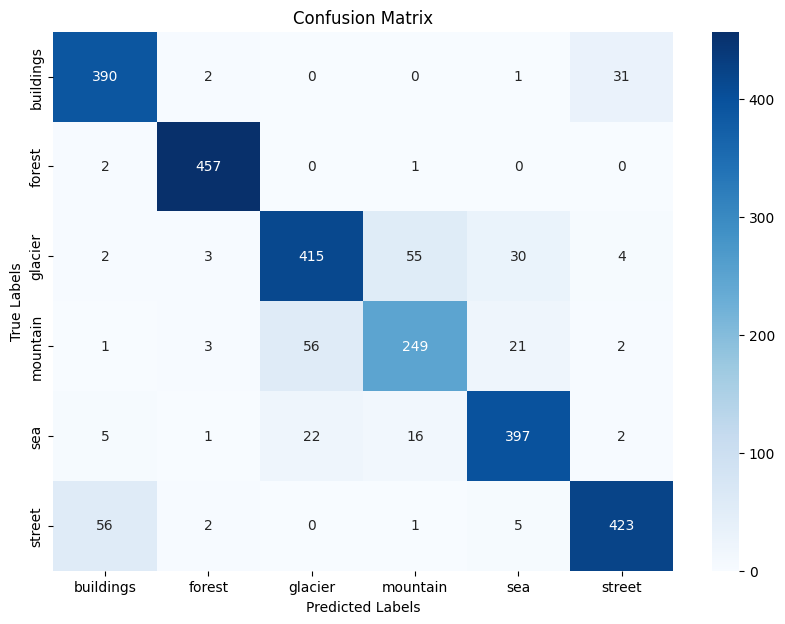

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Step 2: Get predictions
test_generator.reset()  # Reset the generator to avoid any issue while predicting
predictions = model.predict(test_generator, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Step 3: Generate Classification Report (F1 Score, Precision, Recall)
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Save the complete model (architecture + weights + optimizer state)
model.save(r'C:\Users\AFNANKHAN\Desktop\images\complete_model.h5')


In [18]:
# Save the model to a path accessible within the Colab environment
model.save('/content/my_model.keras')

In [21]:
model.save(r"C:\Users\AFNANKHAN\Desktop\my_model.keras")
